# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [9]:
# 基本的なライブラリ
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt

%matplotlib inline

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

# モデル
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import IPCRidge


# 評価指標
from sksurv.metrics import (
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [10]:
def save_model_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    pipeline_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(pipeline_path)
    functions.pickle_dump(pipeline, "{0}/model_pipeline.pkl".format(pipeline_path))

In [11]:
def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

In [12]:
def plot_step_funcs(funcs, label=None, xlabel=None, ylabel=None):
    for fn in funcs:
        plt.step(fn.x, fn(fn.x), where="post", label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

In [13]:
def validate_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    output_pipe_path: str = None,
    is_fitted: bool = False,
):
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
    except:
        print("data pkl file dose not exist")
        return pd.DataFrame()

    # display(_X_train.shape, _y_train.shape)
    # display(_X_test.shape, _y_test.shape)
    if _X_train.shape[0] < 20:
        return

    pipeline_path = "{0}/{1}".format(output_pipe_path, val_step)
    if exists_pipeline(pipeline_path) and is_fitted:
        # 学習済みパイプラインの使用
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
    else:
        # パイプラインの学習の実施
        _model_pipeline = Pipeline(steps=model_order)
        _model_pipeline.fit(_X_train, _y_train)
    _estimator = _model_pipeline[-1]

    # c-index
    _train_score = _estimator.score(_X_train, _y_train)
    _test_score = _estimator.score(_X_test, _y_test)

    _risk_test = _model_pipeline.predict(_X_test)
    print(_risk_test)
    va_times = np.arange(
        pd.DataFrame(_y_test).RFS_MONTHS.min(),
        pd.DataFrame(_y_test).RFS_MONTHS.max(),
        1,
    )
    # cumulative/dynamic auc
    _cph_auc, _cph_mean_auc = cumulative_dynamic_auc(
        _y_train, _y_test, _risk_test, va_times
    )
    print(_cph_mean_auc)

    # 累積AUCの表示
    plt.subplot(1, 1, 1)
    plt.plot(va_times, _cph_auc, label=_estimator.__class__.__name__)
    plt.xlabel("months from surgery")
    plt.ylabel("time-dependent AUC")
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    """
    # plot survival funcs
    _surv_funcs_test = _model_pipeline.predict_survival_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 2)
    plot_step_funcs(
        funcs=_surv_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="surv rate",
    )

    # テストデータ患者のハザード率のプロット
    _chf_funcs_test = _estimator.predict_cumulative_hazard_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 3)
    plot_step_funcs(
        funcs=_chf_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="hazard rate",
    )
    """

    df_score = pd.DataFrame(
        [_train_score, _test_score, _cph_mean_auc],
        index=[
            "train c-index",
            "test c-index",
            "AUC mean",
        ],  # "Integrated Brier Score"],
        columns=[_estimator.__class__.__name__],
    ).round(3)

    if output_pipe_path:
        save_model_pipeline(
            pipeline=_model_pipeline,
            val_step=val_step,
            save_file_path=output_pipe_path,
        )
    return df_score

In [14]:
def loop_exec():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            # print("subgroup: ", subgroup)
            # init each loop
            plt.figure(figsize=(6, 6))
            df_scores = pd.DataFrame(
                index=["train c-index", "test c-index", "AUC mean"]
            )

            for model_order_dict in model_order_dicts:
                input_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                    model_order_dict["model_name"],
                )
                df_score = validate_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    output_pipe_path=output_pipe_path,
                    is_fitted=False,
                )
                df_scores = pd.merge(
                    df_scores, df_score, right_index=True, left_index=True
                )

            try:
                output_result_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                functions.make_dir(output_result_path)
                df_scores.to_csv(output_result_path + "/result.csv")
            except:
                pass

            output_fig_path = "./{0}/{1}/{2}/{3}".format(
                config.FIGURES_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            functions.make_dir(output_fig_path)
            # plt.close()
            plt.title(subgroup)
            plt.savefig(output_fig_path + "/auc.png")
            plt.show();

  0%|                                                                                             | 0/2 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
40
[-1.2984178  -1.39436879  0.76884776  0.86674341  0.064354    0.43441179
  0.15438524  0.7109134   0.45845329 -0.07089138 -1.27032628 -0.20038996
 -0.32016231  0.84974677  0.33503316  0.33431607 -1.23244742 -0.08903897
  0.26589985 -0.08824369 -0.32738978  0.65340893]
nan
[-1.55077004 -2.67570006  0.16134497  7.10647092  2.79396999  1.97438604
 -2.16875364 -1.36888132  1.37286586 -2.36948213  3.1397283   0.31510915
 -0.52834053 -0.61188039 -1.42263475 -1.40326748 -0.47650525 -3.42316078
 -1.8549384  -1.11736764 -3.35151636 -2.24866919]
nan
[ 8.47100123  8.58710108 14.22459121 19.55653328 14.48946268 15.79398936
 12.86581293 17.01126882 13.39420931  9.28676524 10.70354974 14.12554921
 12.55261638 15.05886326 15.91322497 11.70288982 10.38755411 11.23126541
 13.11985584 11.16781847  8.29465154 10.9036312 ]
nan
[10.71773226 10.96351569 12.12165911 12.38505574 11.77698903 12.36906384
 12.

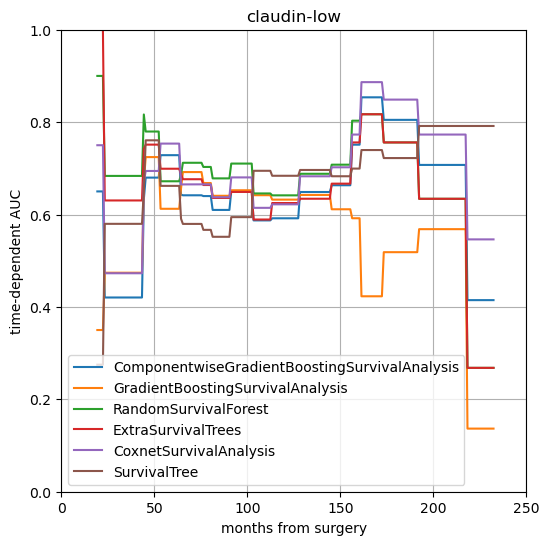

[ 0.12913434 -0.26278361  0.01014319 -0.43382878 -0.51819333  0.6242652
 -0.82594432  0.34926189 -0.1270193   0.30557524  0.22874922  0.07632553
  0.17160792 -0.84738624 -0.08427196 -0.48467521  0.19359584 -0.08385094
  0.02218985 -0.73969119  0.34061518 -0.53943172  0.28478133 -0.27332489
  0.62242043  0.16323856 -0.74475572 -0.34801594  0.26578858  0.34614519
 -0.08231326 -0.03475253 -0.39307374  0.46648852 -0.00120114  0.72990698
  0.58067315 -0.15155369 -0.10733621 -0.62594072 -0.64606283  0.60536339
  0.86586313 -0.10483093 -0.04518186  0.07831336  0.72800062  0.10034924
 -0.15762174 -0.61091557 -0.73753711  0.20972377 -0.31644741 -0.07281056
 -0.03509074 -0.14023553  0.43859154  0.18196608 -0.45324163 -0.77903178
 -0.25626789  0.73665506  0.78563265  0.36021554 -0.64670965  0.30494314
  0.46348584 -0.00196783 -0.25552555]
0.5193114370696317
[-0.28753973 -0.24275605 -0.79384057 -1.14935251 -0.60524618  1.30841658
 -1.94018706 -0.38062518  0.30180938  0.06595242 -0.28142308 -0.3194

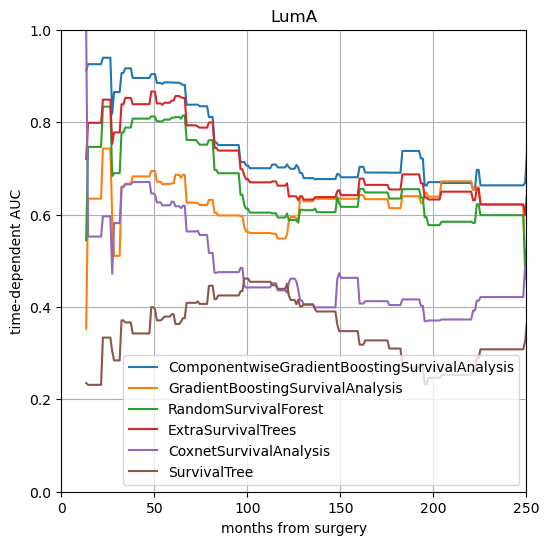

[ 0.02670483  0.01754118 -0.39711538 -0.11301885  0.31253249  0.05421375
 -0.10268206  0.44657245  0.29973323 -0.02559405 -0.33066249  0.34268339
  0.4849848   0.61418306  0.61771541 -0.04393052 -0.50197829 -0.21593877
  0.02906877  0.19419222 -0.10215297  0.3289884   0.09036475  0.15933769
 -0.12437784  0.57724321 -0.00966113 -0.19979727 -0.06318717 -0.15844045
 -0.24522701 -0.58883765 -0.52409692  0.38489675 -0.12635308 -0.32574823
 -0.13883241  0.31777814  0.02909764 -0.13233626 -0.1084566  -0.38063518
 -0.46255188 -0.26329798 -0.46107713 -1.20034342 -0.3500986  -0.38685323]
0.49243074768489487
[ 0.31284096 -0.42196901 -0.46869328  0.09065691  0.50022613 -1.11491007
 -0.65572982 -0.07608502 -0.47491496 -1.5859767  -0.54868333  0.32832316
  1.56265372  0.96413884  0.03733627  0.24026909  0.39019892  3.31452539
 -0.15068896 -1.08053773 -1.12683775  1.56105221 -1.28514843  0.69456045
 -1.14173416  0.12607204 -1.52300495 -1.1328811   0.33007034 -1.09846758
  0.65586187 -1.91981471 -1.06

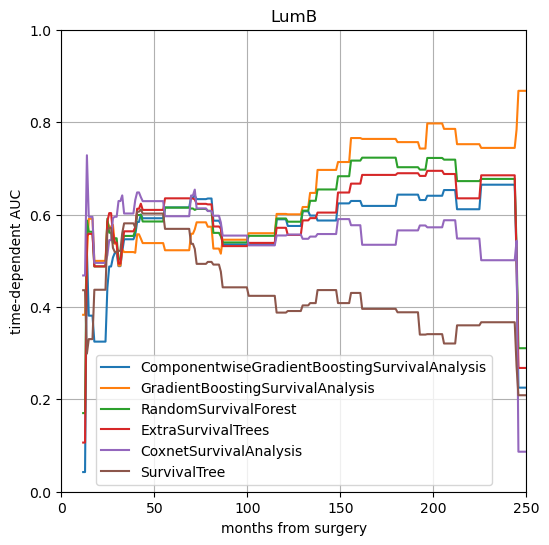

[-0.05662366  0.28979643  1.16208941  0.11102685  0.19609226 -0.32583166
 -0.53580877  0.36880869  0.16989122  0.35862759 -0.1658351  -0.27667198
  0.31900453 -0.58626901 -0.59581368]
0.4775264425668616
[-2.87417541 -1.06942071  3.60260041 -2.98009516  0.46499022 -1.01271406
  1.42063823  6.57140311  1.75204268 -0.39042942 -1.85726629 -1.72419175
 -0.2899165   0.58266084 -5.44892453]
0.6470704903257603
[16.72962774 18.85865052 25.26941203 18.0451263  19.58278781 16.05983352
 15.92874358 25.77455359 18.7084642  17.0793065  14.56838168 15.53713867
 15.3446398  15.81693567 12.80155278]
0.42603464714188066
[17.06084406 17.38303115 18.11335559 17.27659005 17.74613829 16.8811999
 16.4580876  18.00536443 17.16716123 17.78577362 17.06547885 16.77206627
 17.32517934 16.66647989 16.62240089]
0.46442564124594704
[ 0.04777388  0.26773116  0.98324773  0.12640096  0.14395257 -0.26740042
 -0.3836156   0.41918565  0.15806572  0.21347261 -0.15359543 -0.24710904
  0.14716224 -0.38596717 -0.40196911]
0.4

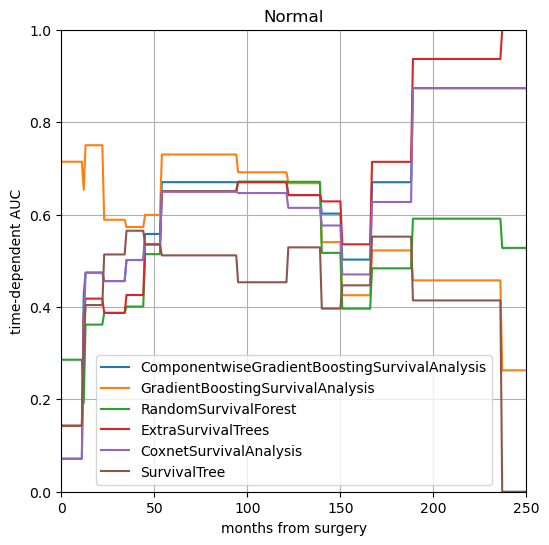

[ 0.01967294 -0.13837642 -0.21434879  0.39746433  0.12017898  0.28631394
 -0.16010919  0.03545219  0.38402685 -0.08281819 -0.6620644  -0.14546216
  0.59818106  0.11342786  0.45569041  0.29308028  0.01134142 -0.1500061
 -0.5423169  -0.46735063  0.85106213 -0.05841085 -0.28507832]
0.43318501062943066
[-0.63983906 -2.39367739 -2.10545845  1.12164596  1.81136943 -1.39614146
  3.69530929  0.2820488   2.54745986  1.62041257 -2.67663426 -1.76460217
 -0.34468405  0.01355997  2.83968367  0.18498376 -1.11572    -1.21393717
 -4.50624085 -1.78587872  3.80184504 -0.35784363 -0.51942156]
0.5537763550669624
[38.32265733 28.01917673 29.38286093 43.96939492 41.79232564 37.42077664
 46.62348193 34.64940943 48.72872462 43.9740884  31.78767207 27.50763316
 38.90140966 42.4340667  41.33355223 38.69494568 27.1019496  31.91292691
 23.25549712 30.29490707 46.93937999 32.82520299 32.06318773]
0.45365327467799144
[35.55743092 32.56801069 32.56288091 36.42865157 34.46578703 35.82294126
 35.81833163 35.71925278 3

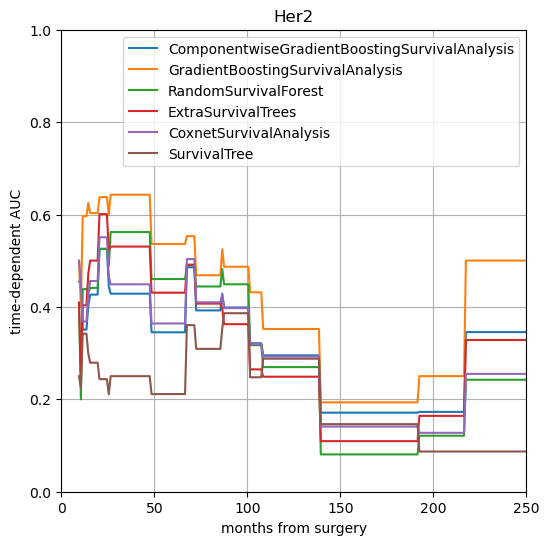

[ 0.14605173  0.43292886  0.26280066 -0.34195487 -0.17294046  0.19516124
  0.19164026 -0.34381648  0.41776806  0.07217921  0.03928084  0.45504103
  0.04155109  0.24346805 -0.51237486 -0.85241894 -0.35481116 -0.06429501
  0.2261827   0.49639624 -0.01181608]
0.36930037911206215
[ 2.56772618  1.36504787  1.33148572 -0.95738499 -1.32392321  1.98679516
  0.55951327  1.31043441  3.49139222  3.36037231 -0.90378515 -0.55924443
  0.67689477 -0.48499449 -0.67793977 -1.64885171  1.1638656  -0.47931342
 -1.62313801  0.08516026  1.87655461]
0.49456809374043914
[31.36483982 30.18339311 28.02423952 17.99748709 21.76802335 32.32473171
 23.21476238 24.96531608 33.01537749 29.11679985 24.05543071 29.87441623
 27.60334336 25.75549379 18.70091433 17.49338392 17.49935137 20.97572388
 22.58786599 26.29166935 24.92151225]
0.4399898589809042
[23.94504145 24.09480198 23.80034932 21.28757284 22.13725255 23.65671898
 22.96133788 22.34130018 23.91887695 24.08830442 22.10493101 24.10442053
 22.88469833 22.92580338

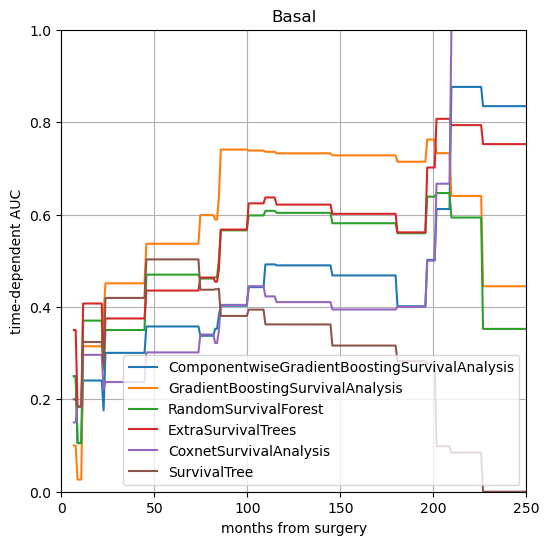

data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


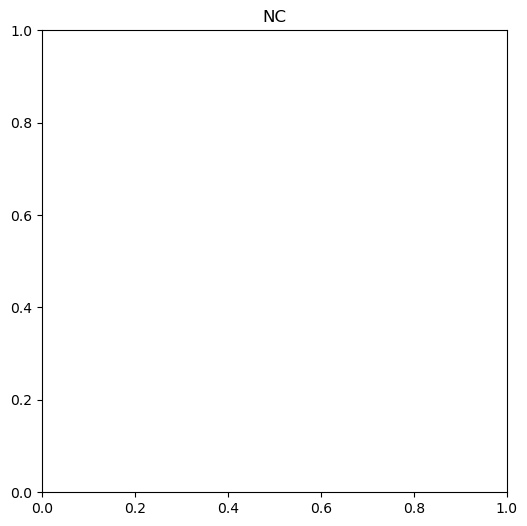

 50%|██████████████████████████████████████████                                          | 1/2 [15:52<15:52, 952.77s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
41
[-1.47734726 -1.48551454  0.92934519  1.00633115 -0.03028819  0.21843153
  0.11081747  0.76362775  0.54664319  0.0666688  -1.33489538 -0.28066657
 -0.63183907  0.86046088  0.37996212  0.46589179 -1.16041797 -0.0530083
  0.36039062  0.00668182 -0.48198332  0.697268  ]
nan
[-1.40834992 -1.99371268  0.13324611  7.10942598  2.58679803  0.96170342
 -1.62456932 -0.95966346  1.29942448 -2.51053282  3.24719299  0.30289266
  1.02763275  1.09705546 -0.4666964  -1.57570937  0.37488534 -3.45072007
 -1.74305271 -2.29205896 -0.41931721 -1.92100063]
nan
[ 8.76032457  8.71956573 14.61283549 18.89257608 14.2381906  14.74827836
 13.19869275 17.07187786 13.89693818  9.59539883 10.5283481  13.37514708
 12.31016167 15.63554853 16.22784272 11.68791813 10.20630098 11.1550286
 12.7399437  11.22118163  8.89751943 10.70107409]
nan
[10.61208675 10.62593616 12.30773579 12.45176553 11.86912471 12.33047831
 12.08

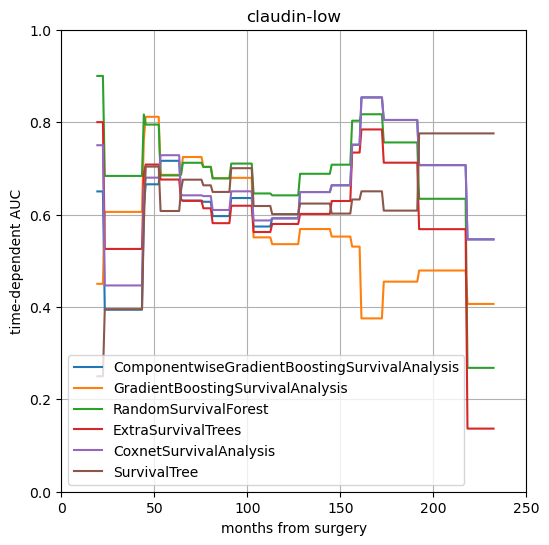

[ 0.14969587 -0.28157103 -0.09849193 -0.41219874 -0.48930977  0.61115029
 -0.7732317   0.38998535 -0.12270753  0.22713972  0.22442358  0.07600801
  0.1444247  -0.85786579 -0.09688471 -0.42171296  0.1930188  -0.08525047
  0.01980613 -0.74847369  0.34934624 -0.51098286  0.27335215 -0.18462927
  0.55580541  0.15241356 -0.75050402 -0.36738937  0.21449461  0.27221098
 -0.12424599 -0.03200481 -0.36985556  0.50834841 -0.00489782  0.7785643
  0.51529751 -0.12986369 -0.13675372 -0.64359482 -0.61017037  0.53306481
  0.9327674  -0.1574016   0.04989547  0.08994266  0.67199075  0.14787149
 -0.19277331 -0.57990658 -0.74029572  0.18485001 -0.33436607 -0.06562311
 -0.03530727 -0.1679469   0.37312525  0.11884986 -0.46665095 -0.70967492
 -0.28376873  0.74119737  0.84939901  0.41500394 -0.66998354  0.28212713
  0.50685549 -0.05621342 -0.24707552]
0.5166983058504911
[ 0.3531549  -0.43590683 -0.93982313 -0.96919392 -0.55279455  1.58564768
 -2.16228084  0.13276783  0.03999162 -0.00946122 -0.30969323  0.1269

In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(40, 42, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                    ComponentwiseGradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": RandomSurvivalForest().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    RandomSurvivalForest().__class__.__name__,
                    RandomSurvivalForest(
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": ExtraSurvivalTrees().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ExtraSurvivalTrees().__class__.__name__,
                    ExtraSurvivalTrees(
                        random_state=config.SEED,
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                    ),
                ),
            ],
        },
        {
            "model_name": CoxnetSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    CoxnetSurvivalAnalysis().__class__.__name__,
                    CoxnetSurvivalAnalysis(n_alphas=10000, fit_baseline_model=True),
                ),
            ],
        },
        {
            "model_name": SurvivalTree().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    SurvivalTree().__class__.__name__,
                    SurvivalTree(random_state=config.SEED),
                ),
            ],
        },
    ]
    loop_exec()

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
[-0.66462255  2.21593867 -1.27814462  1.45696547  2.76449852  2.24821757
  0.99409939 -0.20190022  1.84563881 -1.4872144  -1.10543151 -0.22740884
 -2.86862002 -2.4994759   3.28540206  2.06111759 -0.85222293 -2.29601687
 -1.24969264 -2.80664965  2.56744705 -0.203028  ]
nan


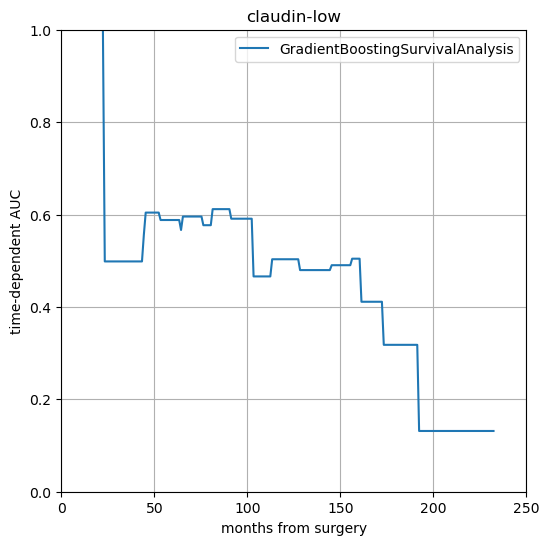

[ 0.81910423 -0.58484384 -0.95913604 -2.3018112  -1.56219809  0.93250135
 -0.87327243  0.18564002  1.24442024 -1.60999113 -1.11712956  2.30353038
 -1.07234573 -0.56338571  0.997924    0.19621639 -0.22702751 -0.58399148
 -0.59322856 -0.40849774  0.150178    0.34805239 -1.04583902  0.01108529
 -1.15205004 -1.0375639  -1.40658384  0.36876524 -1.10959613 -0.15994638
 -0.75289425  1.41856061  0.19988859  0.42653582 -1.91445271  1.0826289
  1.13647902  0.68285639 -0.91364155 -0.58096935 -0.15365437  1.90693158
 -1.1438139   0.81236534  0.2808322   1.00886652  2.19417591 -0.06582985
  1.79697927  0.66783837 -0.53980943  0.43501183 -0.23700754  0.20409208
  1.14055457  0.7487561   0.83525018  0.32674783 -0.16347896  0.54179485
  0.31249431  0.67059009  1.06305821  0.52812711 -1.06762411 -0.38313419
 -0.74068467 -0.07845838 -1.64923572]
0.553528597095901


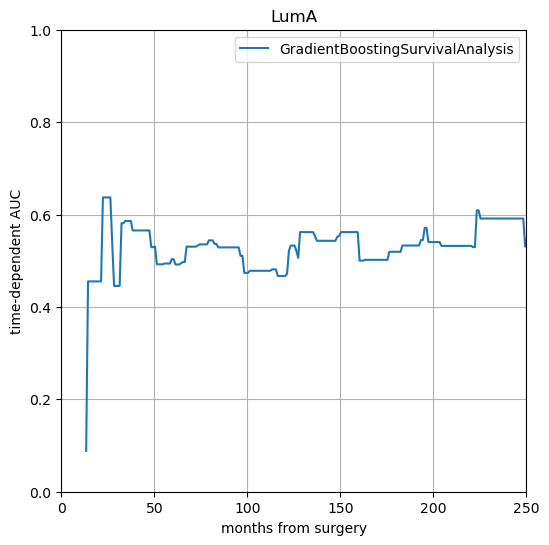

[ 0.21272752 -0.32215311  0.16630748  1.95577856  1.73925862  1.10195455
 -2.35054023 -0.77763882  0.22647233 -0.83464356 -1.2345083  -0.52626951
  0.30845814  1.25271463  2.14934873  0.12254638  0.09900431 -0.95840483
 -0.95572728  0.18676354 -1.78891759  2.06126708 -2.20312203  1.02742418
 -0.52351517 -0.55597651 -1.24912631 -0.56826564  1.00977876 -0.88503086
  1.18006631 -0.59179171 -0.61821216  0.56563572  1.23211081 -0.73985139
  0.4253579   1.13998159  1.36037395 -2.1209076   0.96268123  1.31579767
  1.9802607  -1.4817713  -1.96119203 -2.48570887 -1.00842367 -0.51876672]
0.5722118189801356


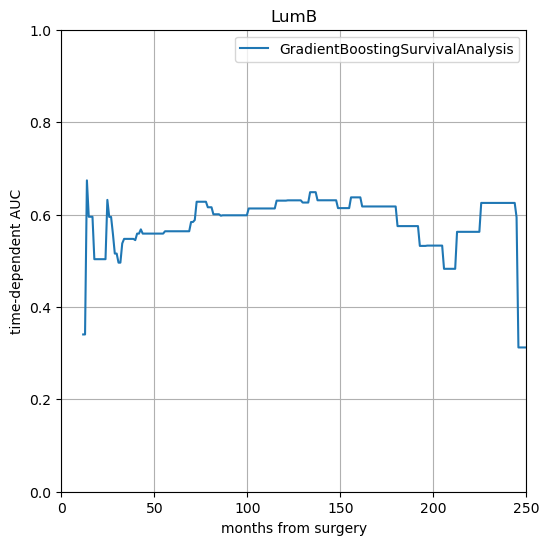

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


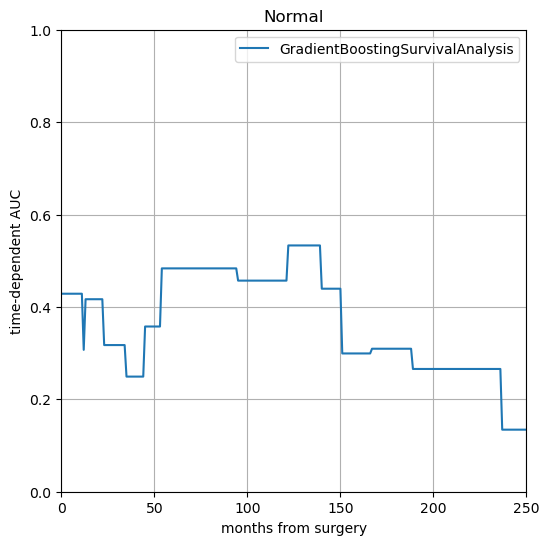

[ 1.40725591  1.13309912  0.55925108  2.14999787 -1.51222863  0.08313924
  2.56049594  1.01472909  0.95363546  0.37068482 -1.67442125 -0.83530815
 -0.69031091  2.60699199  0.70609471  2.18912513 -3.73262535  1.48715848
 -0.22032686  1.32165122  3.32608954  0.91803196 -0.7619596 ]
0.42143877782353695


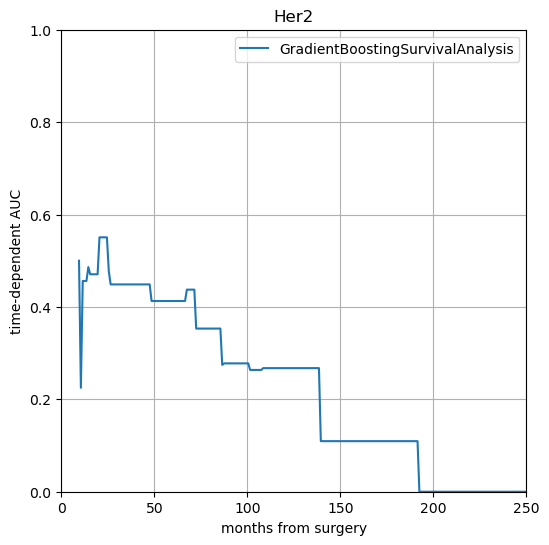

[ 2.39371847 -1.95690802  3.07793154  0.45011248 -1.60195125  1.95873301
  2.05258992  1.04614168  0.69842646  3.49879398  2.91634457  1.19788375
  2.67621899 -0.24916021 -1.64516808 -3.73531453 -1.22339289 -0.5892542
 -1.64226957 -0.52934173  2.09266045]
0.5093594896890004


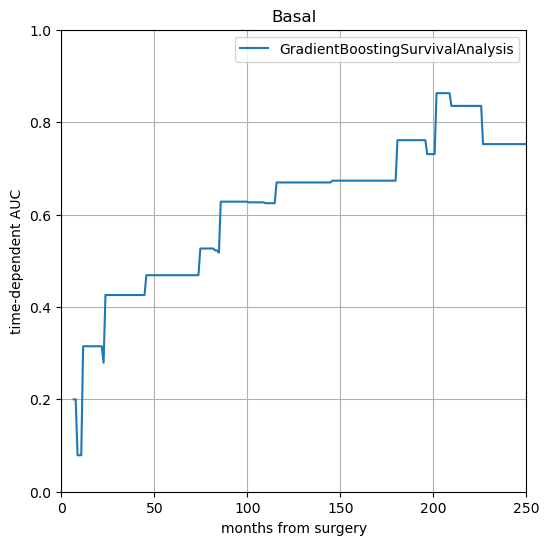

data pkl file dose not exist


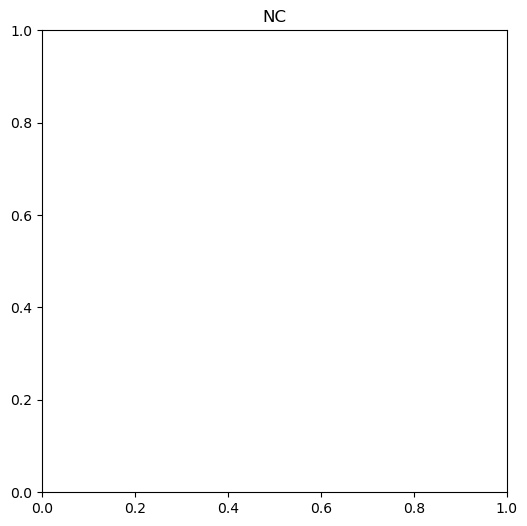

 20%|█████████████████                                                                    | 1/5 [00:15<01:01, 15.27s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
26
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


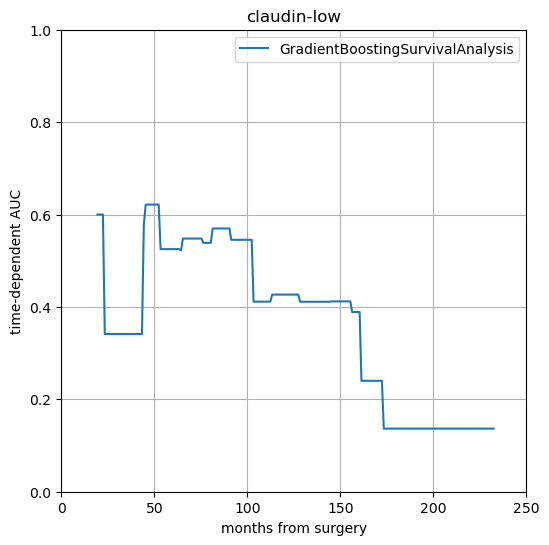

[ 1.1647718  -0.53949264  0.4438762  -1.70980832 -1.54941269  0.80077984
 -1.05099495 -0.15179658  0.84401006 -0.66780516 -1.50551816  1.78093075
 -1.00710227  0.03946767  0.84303905  0.26519874  0.25401803 -0.16249501
 -0.51811747 -0.31855123 -0.09393167  0.62374825 -0.3443578   0.52019119
 -1.37815232 -1.069515   -1.03086422  0.38275894 -1.82158682 -1.08354366
 -0.72341752  1.55322727  0.70841345 -0.55834207 -2.09714071  2.1565477
  0.5031976   0.60478965 -0.76546874  0.43511602  0.30146675  1.14214909
 -0.87733737  0.60440981  1.28289439  0.30904071  1.27869659 -0.0532275
  1.69848755  0.93627411  0.09184524  1.09739257 -0.0333933   0.035852
  0.78272025  0.11357761  1.33186593 -0.26126753  0.02731512 -1.26425058
  0.2255833   0.28592991  1.3726662  -0.05928041 -1.64546081 -0.30889653
 -0.30130764 -0.91933342 -1.42699983]
0.6958686922070627


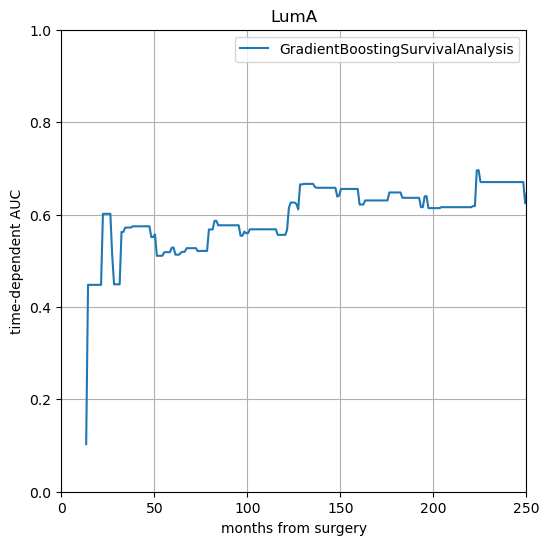

[-0.29816095 -1.37550105 -0.02853549  2.0114589   1.66393582  1.22816119
 -1.48350454 -0.20510831  0.1196093  -0.77380879 -0.46629575  0.06393958
  0.37779217  1.08301354  2.22800792  0.1782986  -0.10879887 -0.26679583
 -1.839408    1.84075266 -2.54185915  3.31476619 -2.05054501  0.86165138
 -0.99669737  0.66222409 -1.9252856  -1.2782884   1.57879547 -1.1672371
  1.55295157 -0.56703377 -0.0603211  -0.39607197 -0.23529291 -0.92975854
  0.91809389  1.3626946   0.04324979 -1.21527289  0.43240992  1.22368563
  1.25254924 -2.38733063 -3.8637504  -3.16976536 -1.81435538 -1.34121186]
0.579269146966861


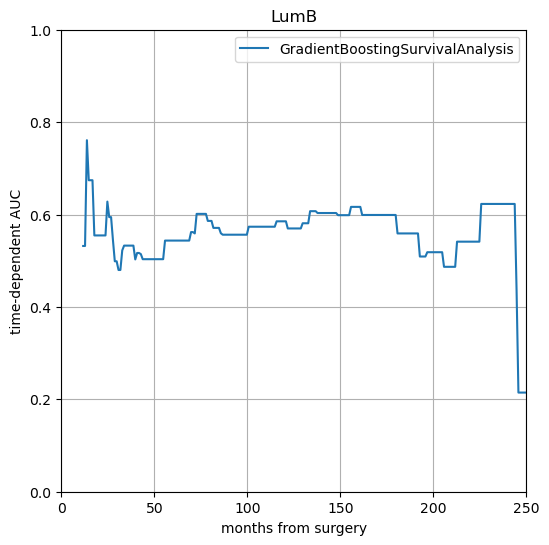

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


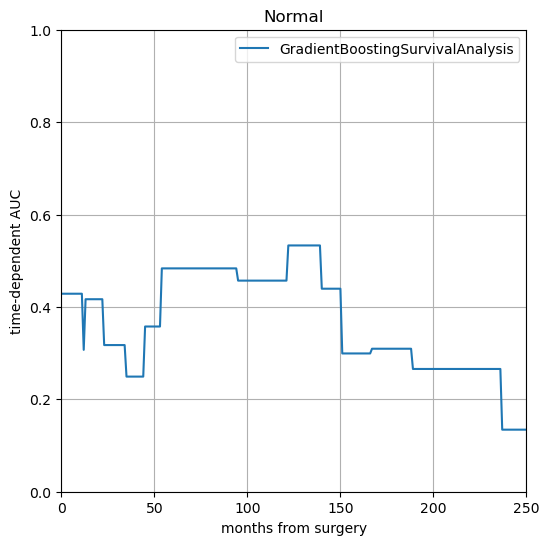

[ 1.40725591  1.13309912  0.55925108  2.14999787 -1.51222863  0.08313924
  2.56049594  1.01472909  0.95363546  0.37068482 -1.67442125 -0.83530815
 -0.69031091  2.60699199  0.70609471  2.18912513 -3.73262535  1.48715848
 -0.22032686  1.32165122  3.32608954  0.91803196 -0.7619596 ]
0.42143877782353695


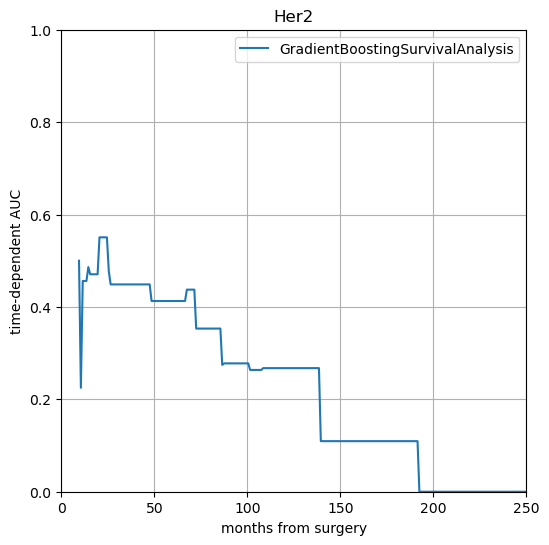

[ 2.39371847 -1.95690802  3.07793154  0.45011248 -1.60195125  1.95873301
  2.05258992  1.04614168  0.69842646  3.49879398  2.91634457  1.19788375
  2.67621899 -0.24916021 -1.64516808 -3.73531453 -1.22339289 -0.5892542
 -1.64226957 -0.52934173  2.09266045]
0.5093594896890004


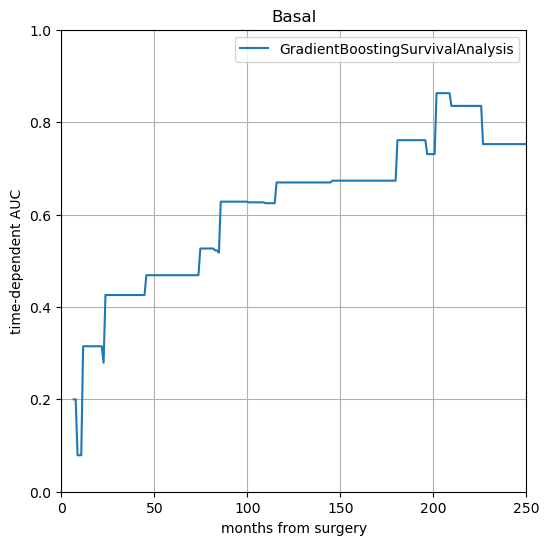

data pkl file dose not exist


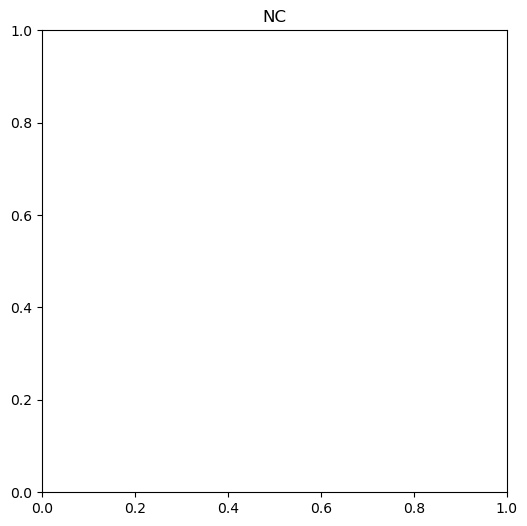

 40%|██████████████████████████████████                                                   | 2/5 [00:25<00:36, 12.19s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
27
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


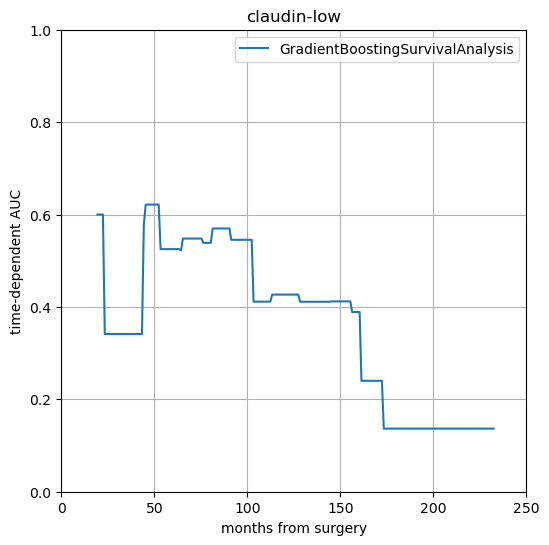

[ 1.1647718  -0.53949264  0.4438762  -1.70980832 -1.54941269  0.80077984
 -1.05099495 -0.15179658  0.84401006 -0.66780516 -1.50551816  1.78093075
 -1.00710227  0.03946767  0.84303905  0.26519874  0.25401803 -0.16249501
 -0.51811747 -0.31855123 -0.09393167  0.62374825 -0.3443578   0.52019119
 -1.37815232 -1.069515   -1.03086422  0.38275894 -1.82158682 -1.08354366
 -0.72341752  1.55322727  0.70841345 -0.55834207 -2.09714071  2.1565477
  0.5031976   0.60478965 -0.76546874  0.43511602  0.30146675  1.14214909
 -0.87733737  0.60440981  1.28289439  0.30904071  1.27869659 -0.0532275
  1.69848755  0.93627411  0.09184524  1.09739257 -0.0333933   0.035852
  0.78272025  0.11357761  1.33186593 -0.26126753  0.02731512 -1.26425058
  0.2255833   0.28592991  1.3726662  -0.05928041 -1.64546081 -0.30889653
 -0.30130764 -0.91933342 -1.42699983]
0.6958686922070627


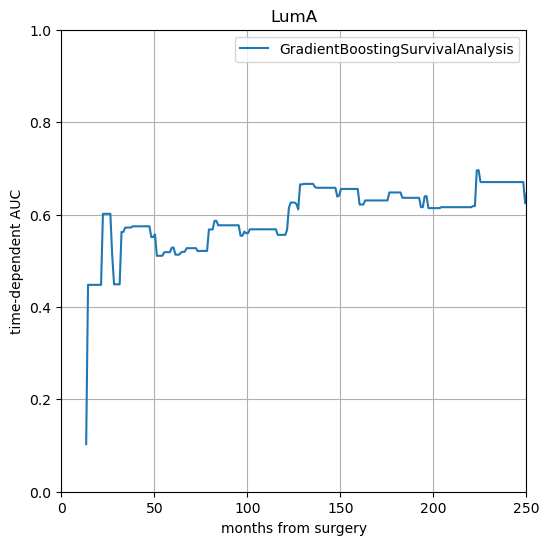

[ 1.64428977 -0.76103864 -0.18748068  2.86509284  1.58245787  0.74890393
 -1.49545217 -0.17286058  0.21275273 -1.02420218 -0.37391356  0.12114964
  0.12581265  1.8086692   2.4658682   0.67607998 -0.21459549 -0.1153092
 -1.79984337  1.27224351 -2.06345232  2.02747614 -1.91230294  0.81348403
  0.18964712 -0.24424723 -1.61392793 -1.08166326  1.56024975 -2.08485317
  0.88786799 -0.59899862 -1.35182685 -0.80349519 -0.16554772 -1.33823589
  0.82039733  1.74852824  0.10308666 -1.17578626  0.3115619   2.33225764
  0.8845358  -2.00924386 -2.44307842 -3.82862556 -1.37270663 -2.10760655]
0.5687912246744259


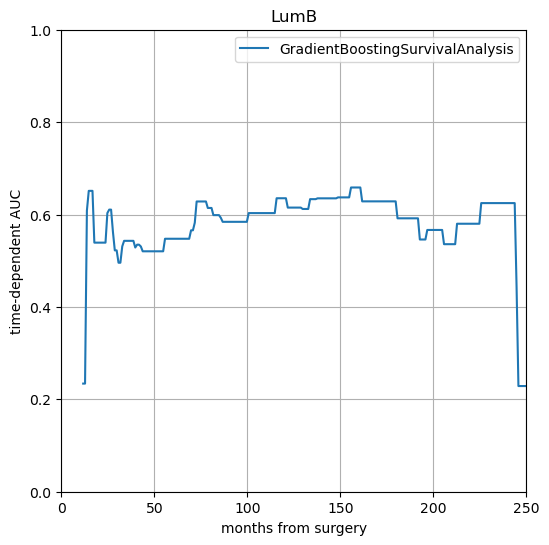

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


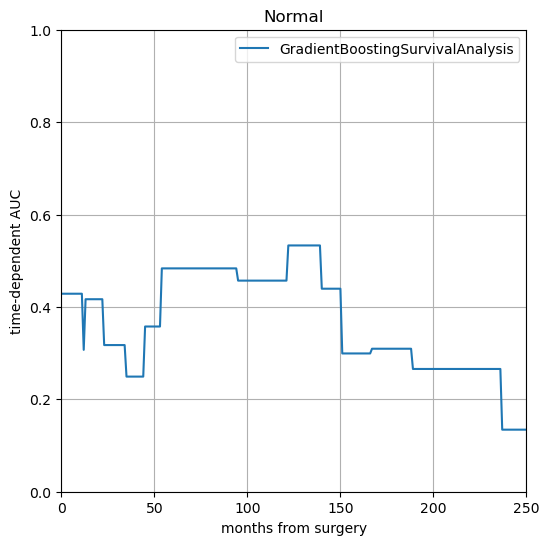

[ 1.34919543 -1.18389027 -1.26579599  0.17816005 -1.16754808 -2.17567451
  3.32885131  0.31683394  3.09045133  2.14762935 -0.80387847 -1.92601247
  0.36578174  2.38212972  1.93157096  0.36036759  0.2851842   0.39983361
 -1.88300049 -0.00970015  3.05880152 -0.18001785  0.72923806]
0.47576321532403243


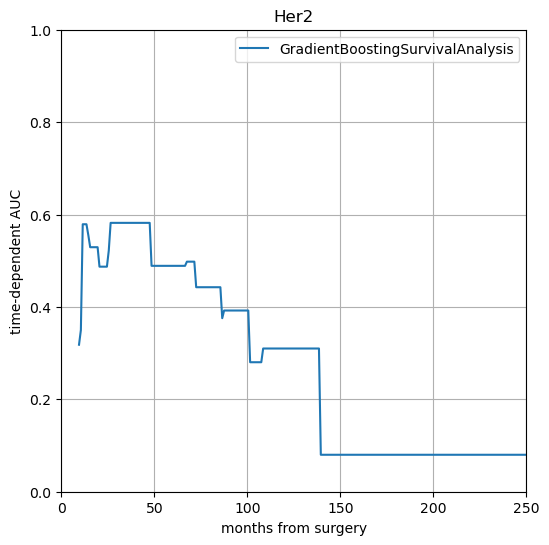

[ 0.68846474 -1.19487744  1.32054531 -0.83613485  0.27150456  2.41322182
  2.27144126 -0.06437624  1.17037912  4.43683958  1.34645155  0.63452683
  2.78674555 -0.94719184 -0.59278584 -2.99379802 -0.07359785 -0.72431269
 -2.5113434  -1.40327955  2.59110329]
0.5842343964857056


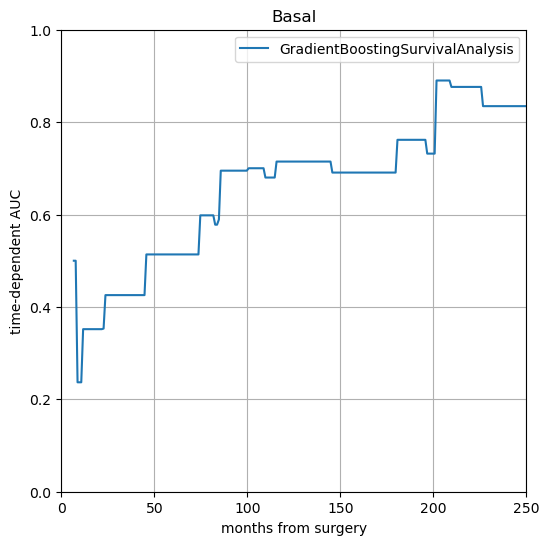

data pkl file dose not exist


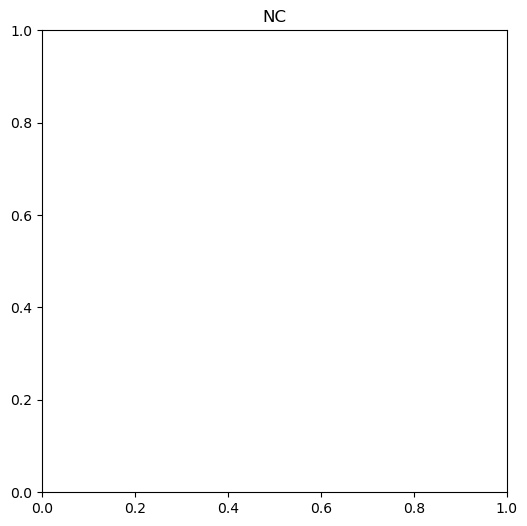

 60%|███████████████████████████████████████████████████                                  | 3/5 [00:35<00:22, 11.31s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
28
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


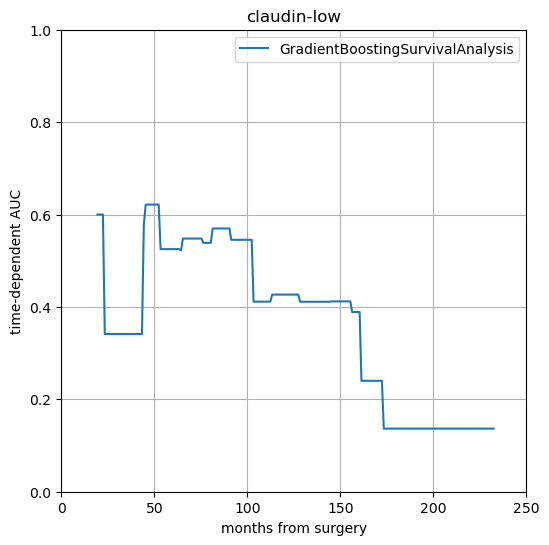

[ 1.10617615 -0.45265927 -0.33802761 -1.46762414 -0.78241575  0.9322115
 -0.49883611 -0.09881251  1.25147795 -0.72838705 -0.50673283  0.85207273
 -1.48214367  0.11318232  1.25221311  0.44299263 -0.21762745  0.34314124
 -0.99491338 -0.49610932 -0.16394825  2.05616793 -0.56744247  0.30301445
 -1.39432312 -1.17714174 -1.32066168  0.09994219 -1.66033633 -0.62327763
 -0.60300316  0.56556577  0.79157991  0.25088545 -2.16851341  2.28507918
  0.74070083  0.10630519 -1.01441445 -0.01415444 -1.32749842  1.11925885
 -1.33491181  0.40356067  0.8768704   0.36878823  1.60011571 -0.25887343
  2.29530142  0.89173059 -0.16457136  1.13094319  0.12744685  0.10523241
  0.87857831  0.13899911  1.05381946  0.26114086 -0.15444825 -1.01459136
  0.42675496  0.34200874  1.35455139 -0.0569336  -1.37614187 -0.34218511
 -0.15855039 -0.66421203 -1.76733485]
0.5701836961105938


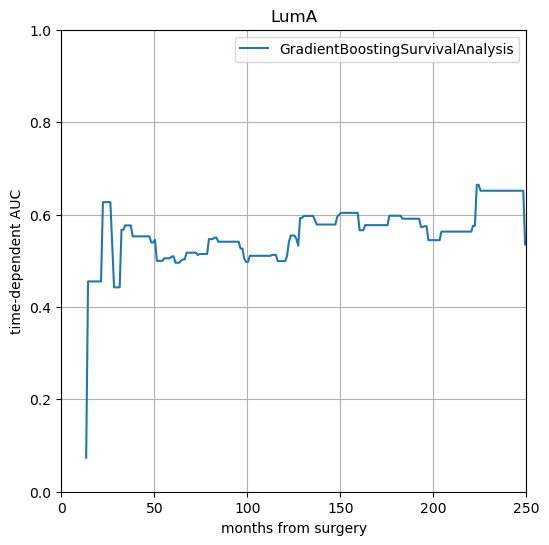

[ 1.7191497  -0.66685647  0.76327452  2.51668866  2.30457919  0.29871587
 -1.1801239   1.0581622   0.34696621 -0.76090491  0.38891632  1.30442354
 -0.00454786  1.97410805  3.32520226  0.62170532  0.52602647  0.66097014
 -2.18166108  0.58514658 -1.90139993  2.95561451 -2.11335523  0.7000122
 -0.57868006 -0.34009371 -1.98021669 -0.89469939  1.37176777 -0.97544648
  1.29085155 -0.86357976 -0.43354325 -0.44701206  0.03258007 -1.43988344
  0.55481938  1.03372136 -0.10825144 -2.1203632   0.28495271  0.54289512
  0.47423777 -2.32884037 -2.26010367 -3.2580263  -1.545901   -1.43237223]
0.5202575052710318


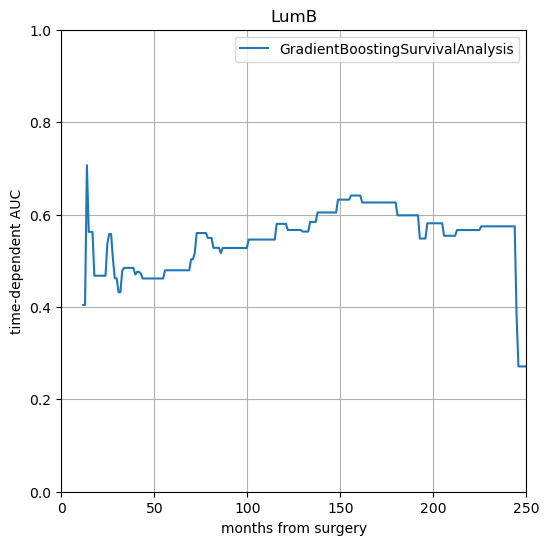

[-1.98669726  2.28946352  1.52728924 -1.18621268  3.18655778  3.70924326
  1.94240186  3.3221282   0.83406232 -2.54777227 -1.46366738 -0.27502787
 -2.56735209  0.13898768 -3.41410953]
0.4016270069248625


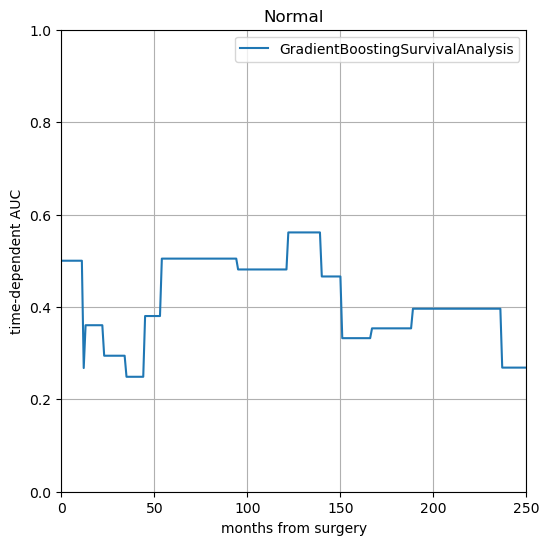

[ 1.77639523 -1.91988973 -2.27689743  0.6832325  -1.76618637 -0.73427336
  2.8247425   1.04227895  5.32478763  2.04341862 -0.62136854 -1.0258449
 -0.69842208  1.29011672  0.42880546 -0.03751928 -1.14721911  0.60118158
 -1.45129288  0.51926737  2.82664289  0.08259001  1.41606465]
0.4996444340372556


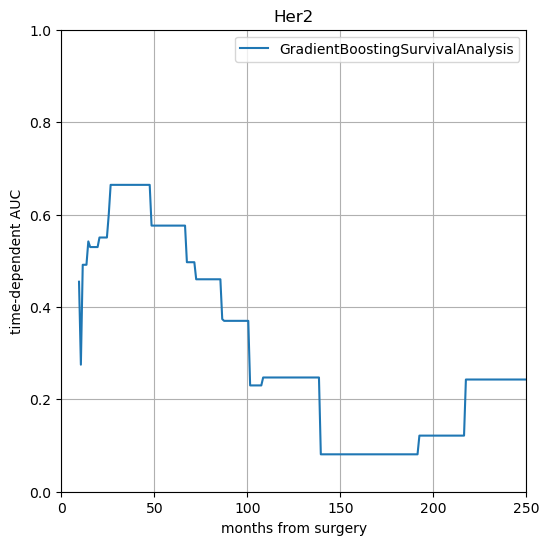

[ 0.74803148 -0.56913885  1.6167754  -0.65310983  0.88290777  2.30777841
  1.99164417 -0.16008121  2.40059367  4.60402103  0.76540465  1.15300215
  2.95152704 -1.31739986 -1.03128464 -2.84901239 -0.45378834 -0.63798402
 -2.88119586 -0.83699931  1.80418106]
0.6116465732232289


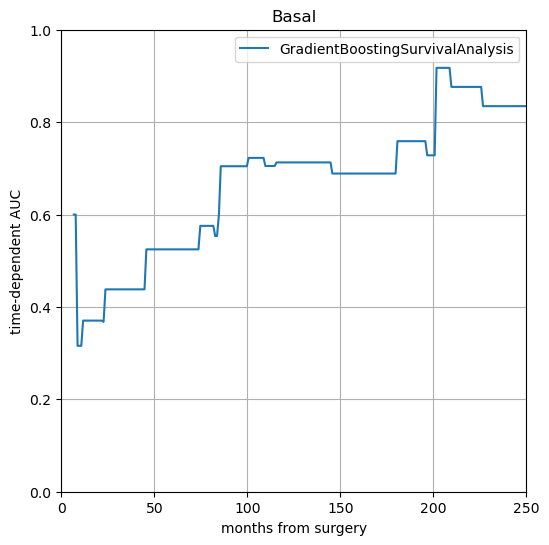

data pkl file dose not exist


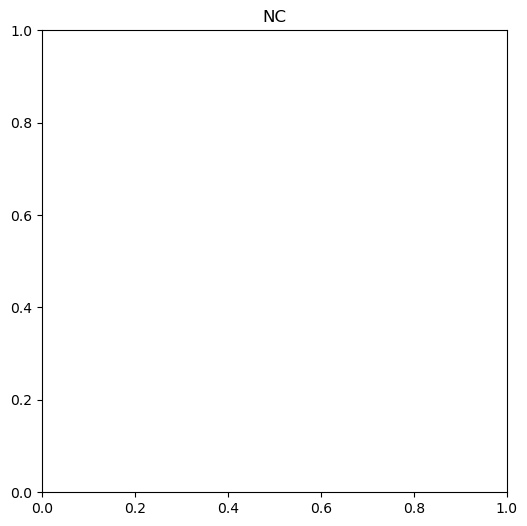

 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:46<00:11, 11.04s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
29
[-0.34636442  1.62586715 -2.02126814  4.04507094  3.72910822  2.34089132
 -0.80610216 -0.56713351  1.42826993 -2.59888449 -0.96971278  2.0356115
 -2.01875026 -1.81423812 -0.5431672   1.43170485  0.35765888 -2.80588969
 -2.16456147 -2.86870926  1.11709408 -1.37231273]
nan


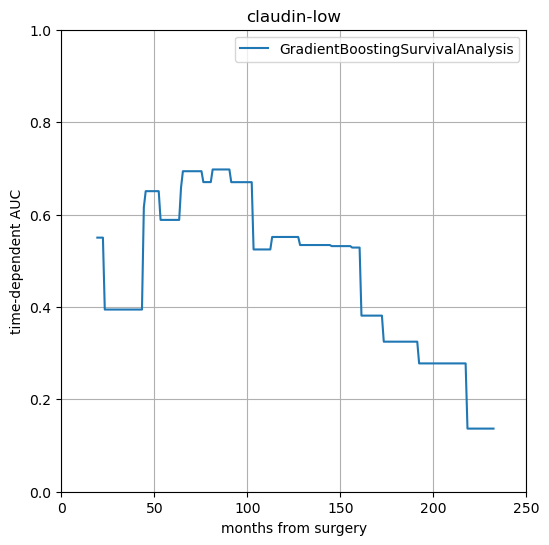

[ 0.64521463 -0.52241969  0.04728249 -1.01568112 -0.26024465  1.34062726
 -1.9349465   0.05875958  1.06386117 -0.69007189 -1.47980258  0.43130659
 -1.43682311  0.24390079  1.17122283  0.72739486 -0.0082983   0.96345143
 -0.73803142 -0.39078375  0.43789474  2.27166809 -0.0388123   0.81503273
 -1.31511735 -0.92543374 -0.96198261  0.11898892 -1.24110203 -0.95495709
 -1.86110433  0.12349721 -0.47840029  0.32687209 -1.815693    2.02388087
  0.93929318  0.41631335 -0.49117073 -0.04247961 -1.83047948  1.16788909
 -1.29839885  0.16700038  1.9062899  -0.61349272  2.26955292 -0.33012923
  1.66347965  0.81227146 -0.74939565  0.9332191   0.1907329   0.37873227
 -1.03679664 -0.72849339  0.10599012  0.75238863 -0.34999436 -1.23180975
  0.64122843  0.56184867  1.39511169  0.02824375 -0.87006382 -0.66031017
  0.12578398  0.66004087 -1.21584388]
0.3773361492970579


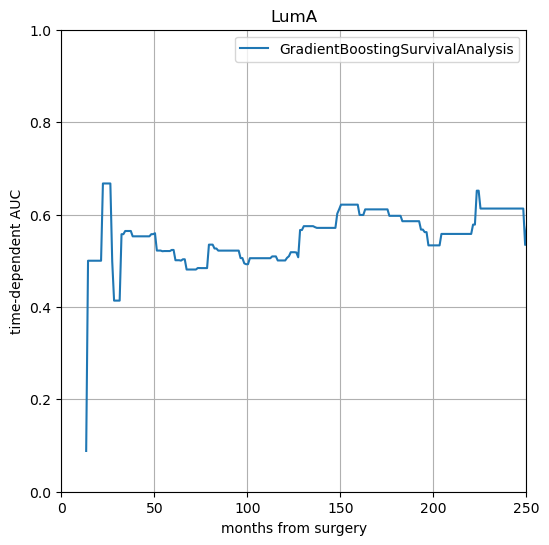

[ 1.41005409  0.01457816  0.66076733  1.52008481  2.16978395 -0.98747827
 -1.12893741  1.33107485  0.57772064 -2.2825947   0.81828288  0.21847421
  0.10310342  2.18177939  2.51747886  0.38334719 -1.45513732  1.87129602
 -1.51401488  0.42463384 -0.83289299  1.06115972 -1.22667311 -0.07324632
 -0.98753913  0.40890379 -1.19338128 -1.86081408  2.05075722  0.4683888
  0.85545663 -1.15977101 -0.93314836 -0.68256008 -0.56411626 -1.51764937
  0.5002916  -0.84389015 -0.43454741 -1.2554608  -1.16385017  2.10999738
  0.2170464  -1.43083836 -0.32663552 -4.40467802 -1.19392753 -2.34677   ]
0.5749231002111117


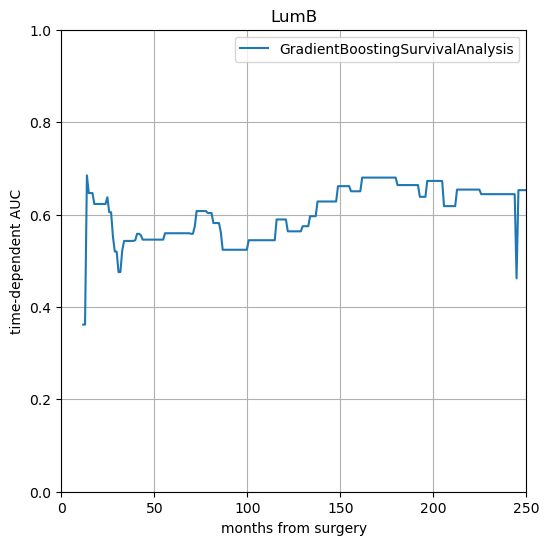

[-1.98669726  2.28946352  1.52728924 -1.18621268  3.18655778  3.70924326
  1.94240186  3.3221282   0.83406232 -2.54777227 -1.46366738 -0.27502787
 -2.56735209  0.13898768 -3.41410953]
0.4016270069248625


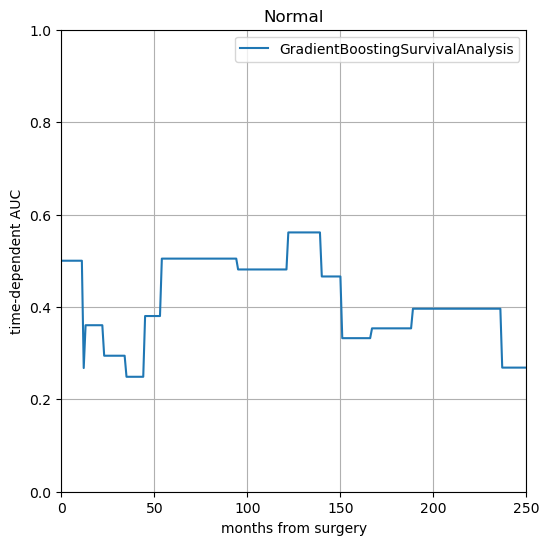

[ 1.77639523 -1.91988973 -2.27689743  0.6832325  -1.76618637 -0.73427336
  2.8247425   1.04227895  5.32478763  2.04341862 -0.62136854 -1.0258449
 -0.69842208  1.29011672  0.42880546 -0.03751928 -1.14721911  0.60118158
 -1.45129288  0.51926737  2.82664289  0.08259001  1.41606465]
0.4996444340372556


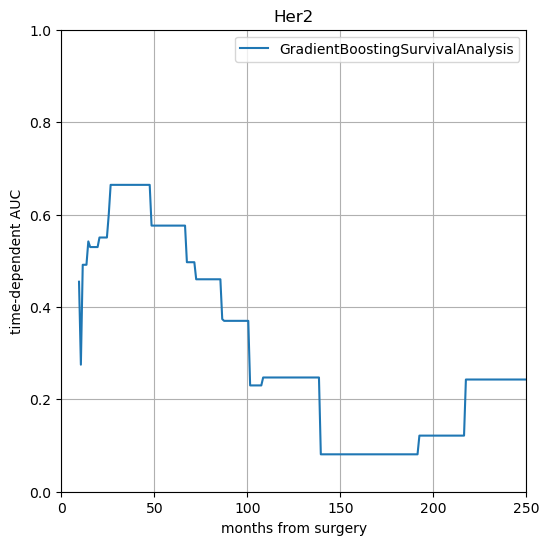

[ 0.74803148 -0.56913885  1.6167754  -0.65310983  0.88290777  2.30777841
  1.99164417 -0.16008121  2.40059367  4.60402103  0.76540465  1.15300215
  2.95152704 -1.31739986 -1.03128464 -2.84901239 -0.45378834 -0.63798402
 -2.88119586 -0.83699931  1.80418106]
0.6116465732232289


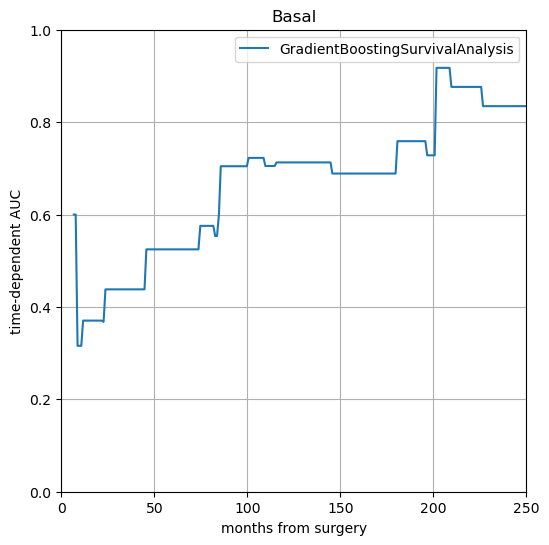

data pkl file dose not exist


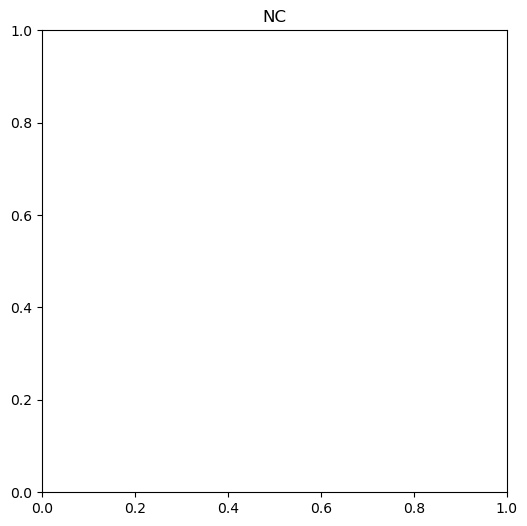

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.27s/it]


In [15]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(25, 30, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__ + "_2",
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
    ]
    loop_exec()

In [17]:
data_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/X.pkl"
)

X = pd.read_pickle(data_path)

pipe_path = (
    config.INTERIM_MODELS_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/ComponentwiseGradientBoostingSurvivalAnalysis/test_set/model_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)

In [11]:
X.shape

(22, 5)

In [12]:
print("LumA")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumA/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("LumB")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Her2")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Her2/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)


print("claudin-low")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Basal")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Basal/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

LumA


array([0.07999636, 0.03472473, 0.0332846 , 0.0229756 , 0.02121804,
       0.01845694, 0.0170286 , 0.01643943, 0.01480088])

LumB


array([0.0721463 , 0.03990887, 0.03137989, 0.02505118, 0.0225195 ,
       0.01793097, 0.01525678, 0.01469092, 0.01276699])

Her2


array([0.13357718, 0.03192168, 0.02959312, 0.02293049, 0.02194096,
       0.02005952])

claudin-low


array([0.0769747 , 0.05560789, 0.04645281, 0.04078616, 0.03282703])

Basal


array([0.07552512, 0.04812878, 0.03409818, 0.02698724, 0.02222222,
       0.02094353, 0.01901346, 0.01553277])

In [12]:
print("25")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("50")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("77")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca75/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

25


array([0.0721463 , 0.03990887, 0.03137989, 0.02505118, 0.0225195 ,
       0.01793097, 0.01525678, 0.01469092, 0.01276699])

50


FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl'

In [1]:
x = np.arange(0, len(pipe[-1].explained_variance_ratio_))
y = pipe[-1].explained_variance_ratio_
plt.title("Matplotlib demo")
plt.xlabel("x axis caption")
plt.ylabel("y axis caption")
# plt.plot(x, y)
plt.plot([0] + list(np.cumsum(y)), "-")
plt.show()

NameError: name 'np' is not defined